In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [11]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

### 생성자 구현
1. 랜덤 잡음 벡터를 받아 완전 연결층으로 7 * 7 * 256 크기의 텐서로 변경
2. 전치 합성곱(Transposed convolution)을 사용하여 7 * 7 * 256 크기의 텐서를 4 * 14 * 128로 변경
    - Transposed convolution은 convolution과 다르다!
3. 배치 정규화와 LeakyReLU를 적용
4. 전치 합성곱을 사용하여 14 * 14 * 128 -> 14 * 14 * 64로 변환(너비, 높이 변경 없음)
5. 배치 정규화, LeakyReLU 사용
6. 전치 합성곱을 사용해 14 * 14 * 64 -> 28 * 28 * 1로 변경
7. tanh 활성화 함수

In [25]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim = z_dim))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')) # padding='same'은 input_size * strides = output_size를 해줌

    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    model.add(Activation('tanh'))

    return model

In [13]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape = img_shape, padding="same"))

    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))

    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))

    model.add(LeakyReLU(alpha=0.1))

    model.add(Flatten())

    model.add(Dense(1, activation='sigmoid'))

    return model

In [14]:
def build_gan(generator, discriminator):

    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model

- 의문점
    - trainable = False 한 뒤, 왜 True로 변경하지 않아도 discriminator가 학습되는가?
- 해답
    - trainable = False 이전에 discriminator가 compile 되었기 때문
    - trainable = False 이후 compile된 GAN은 영향을 받는다
- 참조링크
    - https://stackoverflow.com/questions/58803868/set-trainable-variable-in-gan-implementation-in-tf-keras-properly

In [26]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

### Training

In [28]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [29]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

### 모델 학습

1000 [D loss: 0.141531, acc.: 96.88%] [G loss: 3.012675]
2000 [D loss: 0.343551, acc.: 83.98%] [G loss: 2.179465]
3000 [D loss: 0.421210, acc.: 81.64%] [G loss: 2.158203]
4000 [D loss: 0.403116, acc.: 82.81%] [G loss: 2.182320]
5000 [D loss: 0.270713, acc.: 88.67%] [G loss: 2.565835]
6000 [D loss: 0.172301, acc.: 96.48%] [G loss: 2.698488]
7000 [D loss: 0.362549, acc.: 83.98%] [G loss: 2.596747]
8000 [D loss: 0.215248, acc.: 90.23%] [G loss: 3.320224]
9000 [D loss: 0.307642, acc.: 87.11%] [G loss: 4.110304]
10000 [D loss: 0.224287, acc.: 92.97%] [G loss: 3.383308]
11000 [D loss: 0.321179, acc.: 85.94%] [G loss: 2.987554]
12000 [D loss: 0.310981, acc.: 87.89%] [G loss: 3.618627]
13000 [D loss: 0.257747, acc.: 89.06%] [G loss: 3.187458]
14000 [D loss: 0.321845, acc.: 83.98%] [G loss: 2.739935]
15000 [D loss: 0.385795, acc.: 84.77%] [G loss: 3.477269]
16000 [D loss: 0.109945, acc.: 95.70%] [G loss: 3.867633]
17000 [D loss: 0.345130, acc.: 84.38%] [G loss: 3.011486]
18000 [D loss: 0.256652

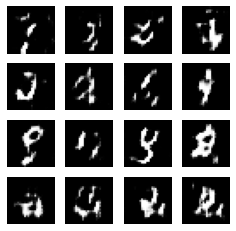

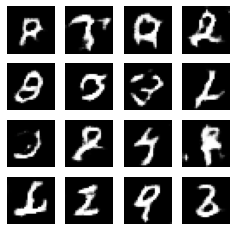

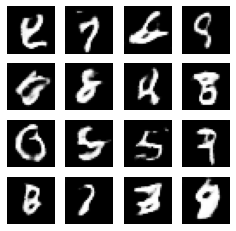

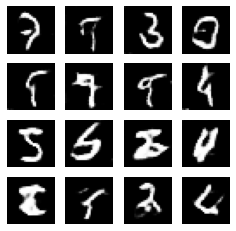

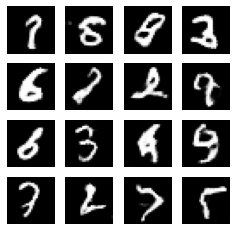

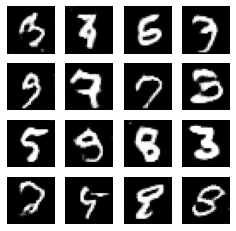

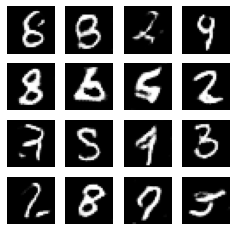

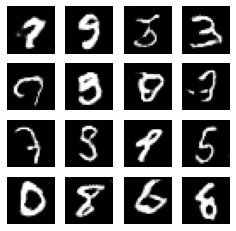

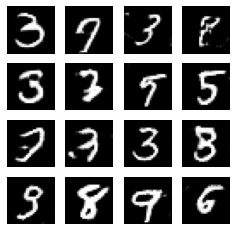

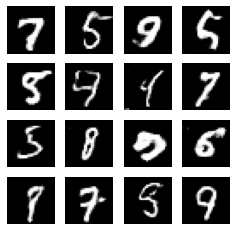

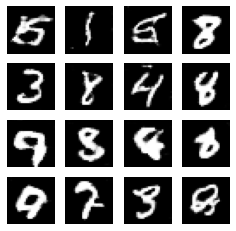

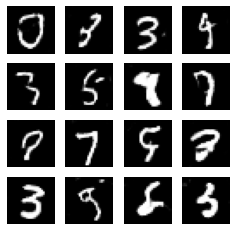

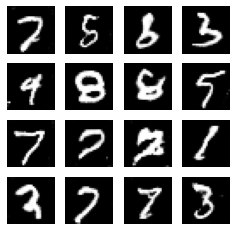

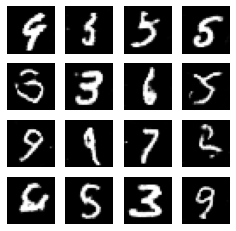

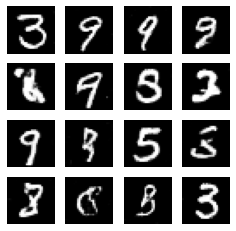

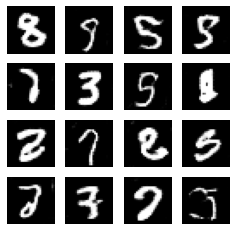

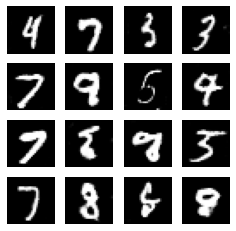

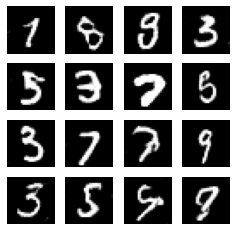

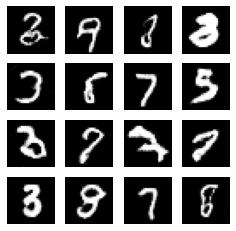

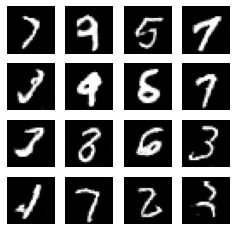

In [30]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)